In [1]:
#pip install pycaret  # need scikit-learn==0.23.2 and python == 3.8

In [2]:
#pip install catboost

In [3]:
#pip install xgboost

In [4]:
#pip install --user optuna

In [5]:
# Standard library import for python.

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 90)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from pycaret.regression import setup, compare_models
from sklearn.model_selection import KFold, cross_val_score

from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

import optuna

---

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.concat([train, test], ignore_index = True). drop(['Id', 'SalePrice'], axis = 1)

In [7]:
target = train['SalePrice']
test_index = train.shape[0]
test_id = test['Id']

In [8]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Un

In [9]:
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [10]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

# 1. Data Cleaning

In [11]:
def evaluate_data(data, column, categorical = True):
    target_value = 'SalePrice'
    unique_values = data[column].unique()
    nunique_values = data[column].nunique()
    null_count = data[column].isnull().sum()
  
    print(f"Label: {column}")
    
    if categorical:
        mode_value = data[column].mode()[0]
        per_group_mean_price = data[[target_value, column]].groupby(column).mean()
        per_group_count = data[['Id', column]].groupby(column).count().rename({'Id': 'Number'}, axis = 1)
        per_group_values = per_group_count.join(per_group_mean_price, on = column).reset_index()
        
        print(f"\nUnique Values: {unique_values}")
        print(f"\nNumber of Unique Values: {nunique_values}")
        print(f"\nNumber of Null Values: {null_count}")
        print(f"\nMode Value: {mode_value}")
        print(f"\nHouses and Price per Category: \n\n{per_group_values}")
        print()
        fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 7))
        sns.barplot(x = column, y = target_value, data = data, ax = axes[0]) # Mean Price per category
        sns.countplot(x = column,  data = data, ax = axes[1]) # Number of houses per category
        
    else:
        mean_value = data[column].mean()
        min_value = data[column].min()
        max_value = data[column].max()
        
        print(f"\nValue Range: {min_value} - {max_value} ")
        print(f"\nNumber of Null Values: {null_count}")
        print(f"\nMean Value: {mean_value}")
        print(f"\nDistribution according to {target_value}: ")
        print()
        plt.figure(figsize=(15,7))
        plt.scatter(data[column], data[target_value])
        plt.xlabel(column)
        plt.ylabel(target_value)
        plt.show()
        

Label: MSSubClass

Unique Values: [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]

Number of Unique Values: 15

Number of Null Values: 0

Mode Value: 20

Houses and Price per Category: 

    MSSubClass  Number      SalePrice
0           20     536  185224.811567
1           30      69   95829.724638
2           40       4  156125.000000
3           45      12  108591.666667
4           50     144  143302.972222
5           60     299  239948.501672
6           70      60  166772.416667
7           75      16  192437.500000
8           80      58  169736.551724
9           85      20  147810.000000
10          90      52  133541.076923
11         120      87  200779.080460
12         160      63  138647.380952
13         180      10  102300.000000
14         190      30  129613.333333



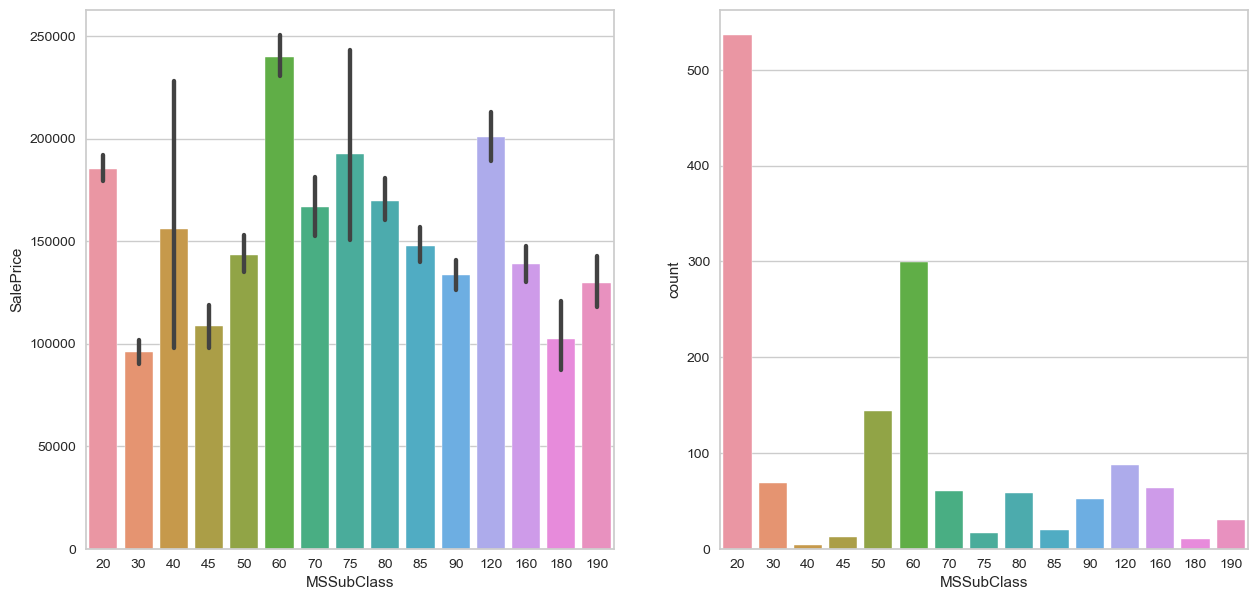

In [12]:
evaluate_data(train, 'MSSubClass', categorical = True)

## Correcting Data Types

In [13]:
data.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
Heating           object
HeatingQC         object


In [14]:
# MSSubClass is categorical but has type 'integer'. It must be turned into a 'string'
data['MSSubClass'] = data['MSSubClass'].astype(str)

## Filling Missing Values

### Categorical Variables 

In [15]:
data.select_dtypes('object').loc[:,data.isna().sum() > 0].columns

Index(['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

In [16]:
# Missing values to be replaced by a constant (These null values actually have an especification in the data description)
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure', 
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType', 
    'GarageFinish', 
    'GarageQual', 
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    data[column] = data[column].fillna('None')

# Missing values to be replaced by the column mode
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',  
    'SaleType'
]:
    data[column] = data[column].fillna(data[column].mode()[0])

In [17]:
# Categorical (object) columns which contain at least one missing value
data.select_dtypes('object').loc[:,data.isna().sum() > 0].columns

Index([], dtype='object')

### Numerical Variables 

In [18]:
# We could use mean imputation, but KNN is a better way to do this
# KNN needs to be applied only to numeric columns with no null values

def knn_impute(df, column): # 'column' has to have null values
    
    df = df.copy()
    numeric_df = df.select_dtypes('number') # numeric columns
    non_na_columns = numeric_df.loc[:, numeric_df.isna().sum() == 0].columns # list of numeric columns with no nulls
    
    y_train = numeric_df.loc[numeric_df[column].isna() == False, column]
    X_train = numeric_df.loc[numeric_df[column].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[column].isna() == True, non_na_columns]
    
    knn =  KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test) # values for imputation
    
    df.loc[df[column].isna() == True, column] = y_pred
    
    return df
    

In [19]:
# Numerical columns which contain at least one missing value
data.select_dtypes('number').loc[:,data.isna().sum() > 0].columns

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

In [20]:
for column in [
    'LotFrontage', 
    'MasVnrArea', 
    'BsmtFinSF1', 
    'BsmtFinSF2', 
    'BsmtUnfSF',
    'TotalBsmtSF', 
    'BsmtFullBath', 
    'BsmtHalfBath', 
    'GarageYrBlt',
    'GarageCars', 
    'GarageArea' 
]:
    data[column] = knn_impute(data, column)[column]

In [21]:
data.isna().sum().sum()

0

# 2. Feature Engineering

In [22]:
# On hold

# 3. Feature Transformation

### Log Transform for Skewed Features

In [23]:
# Some models work better when the data it is dealing with is normally distributed.
# As such, we will apply a transformation to the variables so as to normalize them.
# Normalization is done on numerical features.
# Over +- 0.5 skew is considered skewed data, in need of normalization.
scipy.stats.skew(data['LotFrontage'])

1.3407511399227516

In [24]:
skew_df = pd.DataFrame(data.select_dtypes('number').columns, columns = ['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'] > 0.5

In [25]:
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.340751,1.340751,True
1,LotArea,12.822431,12.822431,True
2,OverallQual,0.197110,0.197110,False
3,OverallCond,0.570312,0.570312,True
4,YearBuilt,-0.599806,0.599806,True
5,YearRemodAdd,-0.451020,0.451020,False
6,MasVnrArea,2.603682,2.603682,True
7,BsmtFinSF1,1.425516,1.425516,True
8,BsmtFinSF2,4.146111,4.146111,True
9,BsmtUnfSF,0.919322,0.919322,True


In [26]:
# Transformation by logarithm

trans_data = data.copy()

for column in skew_df.query("Skewed == True")['Feature'].values:   
    trans_data[column] = np.log1p(data[column])  # log1p = log(x + 1); to avoid log(0) which is undefined
        

### Cosine Transform for Cyclical Features

In [27]:
# Note that variable 'MoSold' refers to a month of the year, and is therefore cyclical, not purely continuous.
# We can apply a Cosine transformation to it, in such a way that numbers in the extremes (1 and 12) are closely linked, 
# in reference to the winter time of the year, as well as months in the middle (6, 7, etc), which refers to summer time.

data['MoSold'].unique()

array([ 2,  5,  9, 12, 10,  8, 11,  4,  1,  7,  3,  6], dtype=int64)

In [28]:
# The best function is -cos(0.5236x), in which 0 and 12 are equal, meanwhile 6 is on the opposite extreme

trans_data['MoSold'] = -np.cos(0.5236 * data['MoSold'])

# 4. Encode Categoricals

In [29]:
enc_data = pd.get_dummies(trans_data)

In [30]:
enc_data

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Fun

# 5. Scaling

In [31]:
scaler = StandardScaler() # centers data to zero with a variance of 1
scaler.fit(enc_data)
scaled_data = pd.DataFrame(scaler.transform(enc_data), index = enc_data.index, columns = enc_data.columns)

In [32]:
scaled_data

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Fun

# 6. Target Transformation

In [33]:
# Done separately from feature transformation for a more careful approach

<AxesSubplot:>

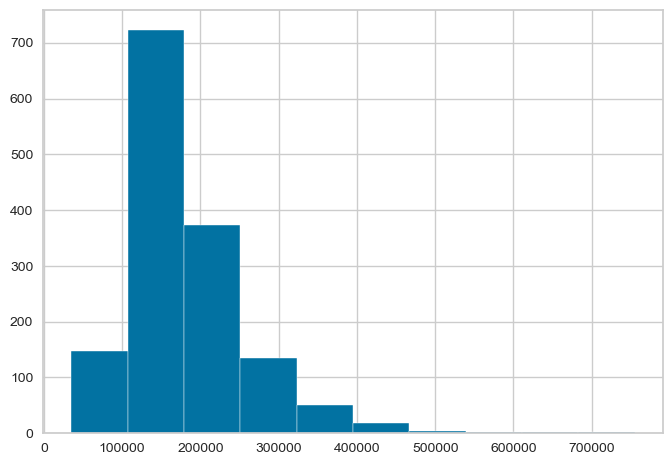

In [34]:
target.hist()

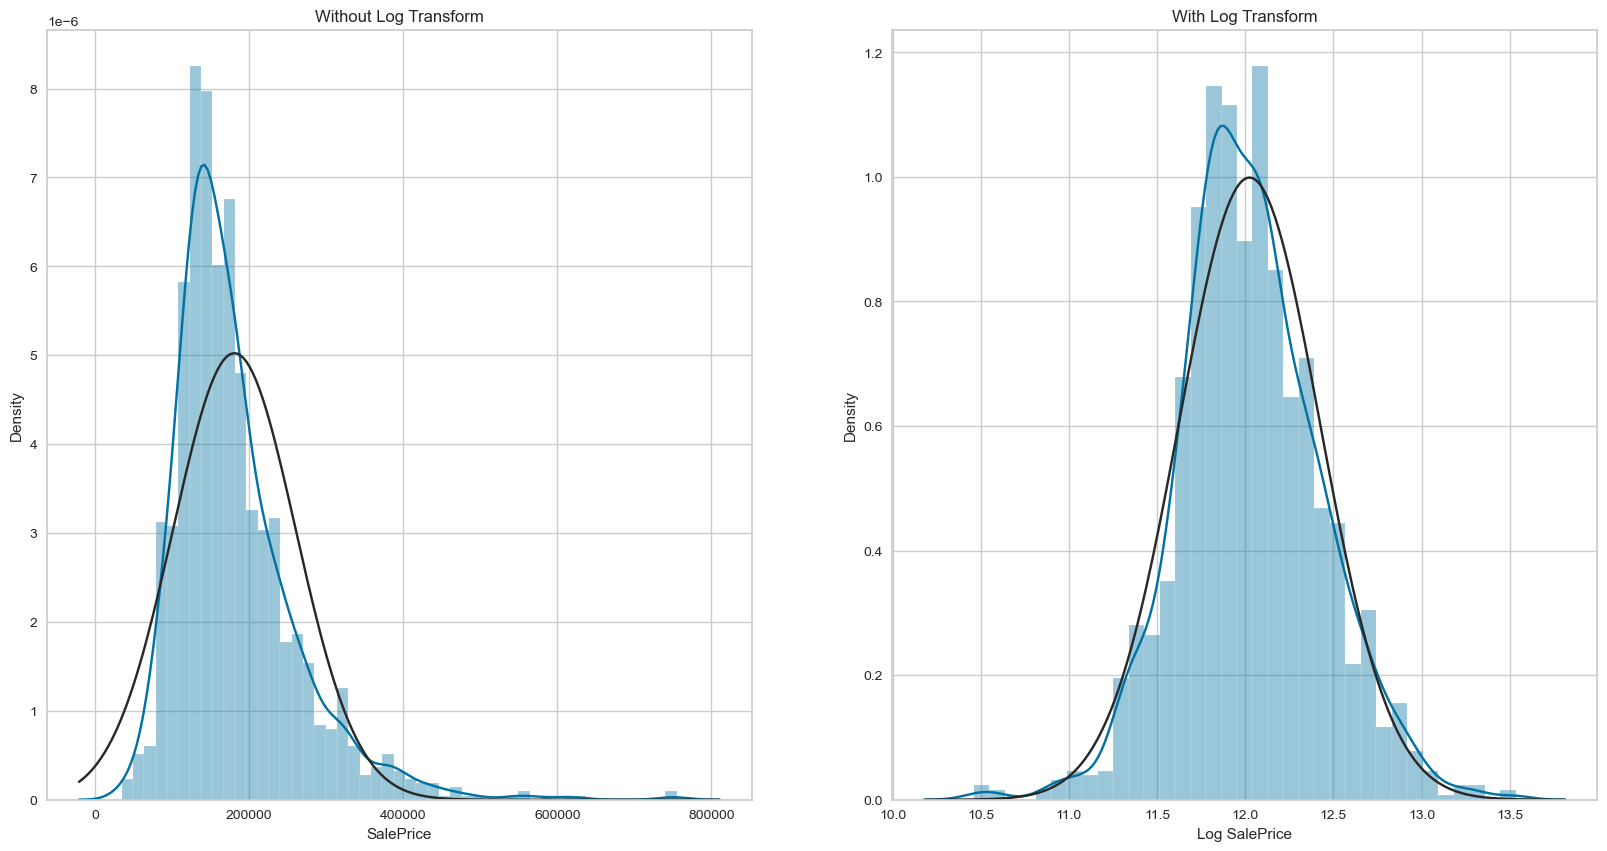

In [35]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
sns.distplot(target, kde = True, fit = scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1,2,2)
sns.distplot(np.log(target), kde = True, fit = scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [36]:
# log transformation
log_target = np.log(target)

# Note that we will be making predictions over log SalePrice, so the data will have to be transformed back 
# later if we are to to analyse the results

# Model Selection 

In [49]:
# split data
pp_train_X = scaled_data[:test_index]
pp_train_y = log_target
pp_test_X = scaled_data[test_index:]

pp_train = pd.concat([pp_train_X, pp_train_y], axis = 1)

In [38]:
#exp1 = setup(data = pp_train, target = 'SalePrice', fold_shuffle=True, session_id=2)

,Description,Value
0,session_id,2
1,Target,SalePrice
2,Original Data,"(1460, 318)"
3,Missing Values,False
4,Numeric Features,44
5,Categorical Features,273
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1021, 300)"


In [39]:
#compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0808,0.0133,0.1148,0.9162,0.0089,0.0068,0.0650
catboost,CatBoost Regressor,0.0798,0.0135,0.1154,0.9151,0.0090,0.0067,5.9120
ridge,Ridge Regression,0.0840,0.0146,0.1201,0.9079,0.0094,0.0070,0.0850
gbr,Gradient Boosting Regressor,0.0893,0.0159,0.1256,0.8995,0.0098,0.0075,0.3290
omp,Orthogonal Matching Pursuit,0.0873,0.0160,0.1252,0.8988,0.0098,0.0073,0.0220
lightgbm,Light Gradient Boosting Machine,0.0899,0.0172,0.1305,0.8918,0.0102,0.0075,0.2100
xgboost,Extreme Gradient Boosting,0.0955,0.0181,0.1335,0.8862,0.0104,0.0080,0.4750
rf,Random Forest Regressor,0.0985,0.0201,0.1409,0.8744,0.0110,0.0083,0.6950
et,Extra Trees Regressor,0.0992,0.0207,0.1433,0.8704,0.0112,0.0083,0.7890
par,Passive Aggressive Regressor,0.1084,0.0209,0.1441,0.8680,0.0112,0.0091,0.0620


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

# Feature Selection

In [42]:
# Feature Selection is more useful in really high dimensional data with a number of redundant, unnecessary information
# It is not much needed on this specific dataset

# Hyperparameter Optimization

In [52]:
# Using optuna for hyperparameter optimization in Bayesian Ridge

def br_objective(trial):
     n_iter = trial.suggest_int('n_iter', 50, 600)
     tol = trial.suggest_loguniform('tol', 1e-8, 10.0)
     alpha_1 = trial.suggest_loguniform('alpha_1', 1e-8, 10.0)
     alpha_2 = trial.suggest_loguniform('alpha_2', 1e-8, 10.0)
     lambda_1 = trial.suggest_loguniform('lambda_1', 1e-8, 10.0)
     lambda_2 = trial.suggest_loguniform('lambda_2', 1e-8, 10.0)
    
     model = BayesianRidge(
         n_iter=n_iter,
         tol=tol,
         alpha_1=alpha_1,
         alpha_2=alpha_2,
         lambda_1=lambda_1,
         lambda_2=lambda_2
     )
    
     model.fit(pp_train_X, pp_train_y)
    
     cv_scores = np.exp(np.sqrt(-cross_val_score(model, pp_train_X, pp_train_y, scoring='neg_mean_squared_error', cv=kf)))
    
     return np.mean(cv_scores)

In [53]:
study = optuna.create_study(direction='minimize')
study.optimize(br_objective, n_trials=100)

[I 2022-11-23 00:33:46,602] A new study created in memory with name: no-name-ebe53d6c-d25b-4a61-8745-a307dd6130b4
[I 2022-11-23 00:33:48,157] Trial 0 finished with value: 1.1396155640096262 and parameters: {'n_iter': 596, 'tol': 0.4695123981313549, 'alpha_1': 0.0001721516381320094, 'alpha_2': 1.106472381743644e-08, 'lambda_1': 0.04797181737680782, 'lambda_2': 0.0004291433644509469}. Best is trial 0 with value: 1.1396155640096262.
[I 2022-11-23 00:33:49,717] Trial 1 finished with value: 1.139420225456952 and parameters: {'n_iter': 533, 'tol': 0.10527330376606946, 'alpha_1': 5.490638229241186e-05, 'alpha_2': 4.531530682547497e-06, 'lambda_1': 7.480137269367129e-06, 'lambda_2': 6.049230439477939e-06}. Best is trial 1 with value: 1.139420225456952.
[I 2022-11-23 00:33:51,288] Trial 2 finished with value: 1.1393951259277768 and parameters: {'n_iter': 587, 'tol': 1.941744507690167e-06, 'alpha_1': 1.8842454715278347e-05, 'alpha_2': 0.0003437399886478465, 'lambda_1': 2.580999309798157e-07, 'la

In [54]:
study.best_params

{'n_iter': 499,
 'tol': 1.5395718712540876e-06,
 'alpha_1': 2.43148000025162e-08,
 'alpha_2': 9.890433047145114,
 'lambda_1': 0.0001742357192327705,
 'lambda_2': 1.0477987166099612e-07}

# Bagging Ensemble

In [55]:
# Unites results from various models into one 'bag' result

In [56]:
catboost_params = {
    'iterations': 6000,
    'learning_rate': 0.005,
    'depth': 4,
    'l2_leaf_reg': 1,
    'eval_metric':'RMSE',
    'early_stopping_rounds': 200,
    'random_seed': 42
}

br_params = {
    'n_iter': 304,
    'tol': 0.16864712769300896,
    'alpha_1': 5.589616542154059e-07,
    'alpha_2': 9.799343618469923,
    'lambda_1': 1.7735725582463822,
    'lambda_2': 3.616928181181732e-06
}

lightgbm_params = {
    'num_leaves': 39,
    'max_depth': 2,
    'learning_rate': 0.13705339989856127,
    'n_estimators': 273
}

ridge_params = {
    'alpha': 631.1412445239156
}

In [57]:
models = {
    "catboost": CatBoostRegressor(**catboost_params, verbose=0),
    "br": BayesianRidge(**br_params),
    "lightgbm": LGBMRegressor(**lightgbm_params),
    "ridge": Ridge(**ridge_params),
    "omp": OrthogonalMatchingPursuit()
}

In [58]:
for name, model in models.items():
    model.fit(pp_train_X, pp_train_y)
    print(name + " trained.")

catboost trained.
br trained.
lightgbm trained.
ridge trained.
omp trained.


# Evaluate

In [59]:
results = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, pp_train_X, pp_train_y, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

In [60]:
results

{'catboost': array([1.11711495, 1.09413224, 1.10662303, 1.1622224 , 1.15274894,
        1.10435166, 1.12996133, 1.10015723, 1.12774341, 1.13316735]),
 'br': array([1.12409634, 1.10750549, 1.1265105 , 1.16965029, 1.15502503,
        1.12802536, 1.12784476, 1.10394044, 1.18725554, 1.13687878]),
 'lightgbm': array([1.13196838, 1.10317125, 1.10841081, 1.17311985, 1.16645211,
        1.11089638, 1.13598985, 1.11233818, 1.14894256, 1.14010729]),
 'ridge': array([1.12533234, 1.11031047, 1.12878484, 1.1729706 , 1.16001545,
        1.12060953, 1.13213845, 1.10705903, 1.18043731, 1.13946312]),
 'omp': array([1.12550453, 1.09788011, 1.11981216, 1.17679697, 1.1555808 ,
        1.16092027, 1.13376685, 1.10647897, 1.19143393, 1.13965602])}

In [61]:
for name, result in results.items():
    print("----------\n" + name)
    print(np.mean(result))
    print(np.std(result))

----------
catboost
1.1228222536130272
0.0214549624146796
----------
br
1.1366732510206332
0.025138152896216025
----------
lightgbm
1.133139665861016
0.023351652364707334
----------
ridge
1.137712113864746
0.02411656858784082
----------
omp
1.1407830606340297
0.028684727647371858


---

# Combining Predictions

In [62]:
final_predictions = (
    0.4 * np.exp(models['catboost'].predict(pp_test_X)) +
    0.2 * np.exp(models['br'].predict(pp_test_X)) +
    0.2 * np.exp(models['lightgbm'].predict(pp_test_X)) +
    0.1 * np.exp(models['ridge'].predict(pp_test_X)) +
    0.1 * np.exp(models['omp'].predict(pp_test_X))
)

In [63]:
final_predictions

array([124034.29640684, 159119.48946318, 186334.16063249, ...,
       165616.86400637, 116805.21755438, 224923.42512088])

# Kaggle Submission

In [64]:
# We will use Cat Boost as a baseline model to test results
baseline_model = CatBoostRegressor(verbose = 0)
baseline_model.fit(pp_train_X, pp_train_y)
log_pred = baseline_model.predict(pp_test_X)

In [65]:
pred = np.exp(log_pred)

In [66]:
# evaluation of baseline model
kf = KFold(n_splits = 10)
results = cross_val_score(baseline_model, pp_train_X, pp_train_y, scoring = 'neg_mean_squared_error', cv = kf)

In [67]:
np.exp(np.sqrt(np.mean(-results)))

1.125864559654639

In [68]:
submission1 = pd.DataFrame({'Id' : test_id, 'SalePrice' : pred})

In [69]:
#submission1.to_csv('HousePrices_CatBoost.csv', index = False)

In [70]:
# Final prediction

final_submission = pd.DataFrame({'Id' : test_id, 'SalePrice' : final_predictions})

In [71]:
final_submission.to_csv('HousePrices_Final.csv', index = False)